In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import utils
from utils.get_nn_models import *
from utils.sbiutils import *
from utils.torchutils import *
from inference.base import *
import torch
import pickle
import seaborn as sns
from inference.snpe.snpe_c import SNPE_C as SNPE
# from networks.summary_nets import LotkaSummary

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)
        
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
def oup(theta, n=50, N=100):
    if len(theta.shape) == 1:
        theta1 = theta[0]
        theta2 = torch.exp(theta[1])
    else:
        theta1 = theta[0, 0]
        theta2 = torch.exp(theta[0, 1])

    # noises
    T, d = 10.0, n+1
    dt = T/d
    Y = torch.zeros([N, n])
    Y[:, 0] = 10
    for i in range(N):
        w = torch.normal(0., 1., size=(n,1))

        for t in range(n-1):
            mu, sigma = theta1*(theta2 - Y[i, t])*dt, 0.5*(dt**0.5)*w[t]
            Y[i, t+1] = Y[i, t] + mu + sigma
    return Y

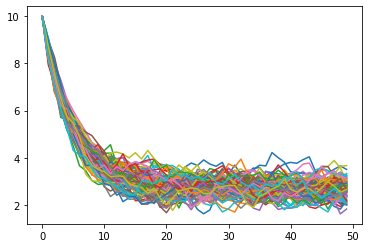

In [3]:
theta = torch.tensor([1, 1])
Y = oup(theta)
for i in range(100):
    plt.plot(range(50), Y[i])

In [4]:
prior = [Uniform(torch.zeros(1), torch.ones(1)),
         Uniform(-2*torch.zeros(1), 2*torch.ones(1))]
simulator, prior = prepare_for_sbi(oup, prior)

num_simulations = 4000

/Users/huangd5/Library/CloudStorage/OneDrive-AaltoUniversity/Projects/Robust SBI/Robust-SBI/utils/user_input_checks.py:64: UserWarning: Prior was provided as a sequence of 2 priors. They will be
            interpreted as independent of each other and matched in order to the
            components of the parameter.
  warnings.warn(


In [99]:
theta, x = simulate_for_sbi(oup, prior, num_simulations=num_simulations)
x = x.reshape(num_simulations, 100, 50).to(device)
theta = theta.to(device)
np.save("data/oup_x_4000.npy", x)
np.save("data/oup_theta_4000.npy", theta)

Running 4000 simulations.:   0%|          | 0/4000 [00:00<?, ?it/s]

In [5]:
x = torch.tensor(np.load("data/oup_x_4000.npy")).to(device)
theta = torch.tensor(np.load("data/oup_theta_4000.npy")).to(device)
print("x shape", x.shape)
print("theta shape", theta.shape)

x shape torch.Size([4000, 100, 50])
theta shape torch.Size([4000, 2])


In [6]:
class OUPSummary(nn.Module):
    def __init__(self, input_size, hidden_dim):
        super(OUPSummary, self).__init__()

        self.hidden_dim = hidden_dim
        self.input_size = input_size
        self.num_layers = 1
        self.lstm = nn.LSTM(1, self.hidden_dim, self.num_layers, batch_first=True)

        self.conv = nn.Sequential(nn.Conv1d(self.input_size, self.hidden_dim, 3, 2),
                                  nn.Conv1d(self.hidden_dim, self.hidden_dim, 3, 2),
                                  nn.Conv1d(4, self.hidden_dim, 3, 3),
                                  nn.AvgPool1d(3))
        self.fc = nn.Linear(self.hidden_dim, 4)

    def forward(self, Y):
        current_device = Y.device
        batch_size = Y.size(0)
#         embeddings_conv = self.conv(Y.reshape(-1, 1, 40)).reshape(-1, 100, 4)
#         stat_conv = torch.mean(embeddings_conv, dim=1)

        hidden, c = self.init_hidden(100*batch_size, current_device)
        out, (embeddings_lstm, c) = self.lstm(Y.reshape(100*batch_size, 50, 1), (hidden, c))

        embeddings_lstm = embeddings_lstm.reshape(batch_size, 100, self.hidden_dim)

        stat_lstm = torch.mean(embeddings_lstm, dim=1)
        out = self.fc(stat_lstm)

#         stat = torch.cat([stat_conv, stat_lstm], dim=1)
        
        return embeddings_lstm, out

    def init_hidden(self, batch_size, current_device):
        hidden = torch.zeros(1*self.num_layers, batch_size, self.hidden_dim).to(current_device)
        c = torch.zeros(1*self.num_layers, batch_size, self.hidden_dim).to(current_device)
        return sum_net_normal = OUPSummary(input_size=1, hidden_dim=32).to(device)

neural_posterior_normal = posterior_nn(
    model="maf", 
    embedding_net=sum_net_normal, 
    hidden_features=20, 
    num_transforms=3)

inference_normal = SNPE(prior=prior, density_estimator=neural_posterior_normal, device="cuda:0")
density_estimator_normal = inference_normal.append_simulations(theta, x.unsqueeze(1)).train(corrupt_data_training="none")
posterior_normal = inference_normal.build_posterior(density_estimator_normal)hidden, c

In [ ]:
sum_net_normal = OUPSummary(input_size=1, hidden_dim=32).to(device)

neural_posterior_normal = posterior_nn(
    model="maf", 
    embedding_net=sum_net_normal, 
    hidden_features=20, 
    num_transforms=3)

inference_normal = SNPE(prior=prior, density_estimator=neural_posterior_normal, device="cuda:0")
density_estimator_normal = inference_normal.append_simulations(theta, x.unsqueeze(1)).train(corrupt_data_training="none")
posterior_normal = inference_normal.build_posterior(density_estimator_normal)

 Training neural network. Epochs trained: 120

In [ ]:
theta_gt = torch.tensor([0.5, 1.0])

obs = oup(theta_gt).to(device)

post_samples_normal = posterior_normal.sample((10000,), x=obs.reshape(1, 100, 50))
# post_samples_robust = posterior_robust.sample((10000,), x=obs.reshape(1, 100, 40))

plt.figure(figsize=(16,8))
plt.subplot(2, 2, 1)
plt.axvline(x=theta_gt[0][0],ls="-",c="black", label="True value")
sns.distplot(post_samples_normal[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="theta 1 - normal")
# sns.distplot(post_samples_robust[:, 0].cpu().numpy(), color='red', kde=False, norm_hist=True, label="theta 1 - robust")
plt.legend()

plt.subplot(2, 2, 2)
plt.axvline(x=theta_gt[0][1],ls="-",c="black", label="True value")
sns.distplot(post_samples_normal[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="theta 2 - normal")
# sns.distplot(post_samples_robust[:, 1].cpu().numpy(), color='red', kde=False, norm_hist=True, label="theta 2 - robust")
plt.legend()

plt.subplot(2, 2, 3)
plt.axvline(x=theta_gt[0][2],ls="-",c="black", label="True value")
sns.distplot(post_samples_normal[:, 2].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="theta 1 - normal")
# sns.distplot(post_samples_robust[:, 0].cpu().numpy(), color='red', kde=False, norm_hist=True, label="theta 1 - robust")
plt.legend()

plt.subplot(2, 2, 4)
plt.axvline(x=theta_gt[0][3],ls="-",c="black", label="True value")
sns.distplot(post_samples_normal[:, 3].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="theta 2 - normal")
# sns.distplot(post_samples_robust[:, 1].cpu().numpy(), color='red', kde=False, norm_hist=True, label="theta 2 - robust")
plt.legend()

plt.show()